In [ ]:
% pip install numpy pycimg opencv-python nibabel scikit-image scipy surface-distance matplotlib

In [17]:
import cv2
import nibabel as nib
import numpy as np
from pycimg import CImg
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage import filters
import surface_distance
import matplotlib.pyplot as plt

In [18]:
def reconstruct(marker: np.ndarray, mask: np.ndarray, radius: int = 1):
    kernel = np.ones(shape=(radius * 2 + 1,) * 2, dtype=np.uint8)
    while True:
        expanded = cv2.dilate(src=marker, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=mask, dst=expanded)
        if (marker == expanded).all():
            return expanded
        
        marker = expanded

In [19]:
def binarize(lungs, max_val):
    lungs_bin_inv = np.zeros(lungs.T.shape)
    for i, dim in enumerate(lungs.T):
        _, lungs_bin_inv[i] = cv2.threshold(dim, -320, max_val, cv2.THRESH_BINARY_INV)

    lungs_bin_inv = lungs_bin_inv.T
    return lungs_bin_inv

def predict_bodymask(lungs, max_val):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    bodymask_pred = np.zeros(lungs.T.shape)
    for i, dim in enumerate(lungs.T):
        _, bin = cv2.threshold(dim, -200, max_val, cv2.THRESH_BINARY)
        img = cv2.erode(bin, kernel, iterations=1)
        img = cv2.dilate(img, kernel, iterations=1)
        img_neg = np.logical_not(img).astype(np.uint8)
        border_marker = np.zeros(img.shape)
        border_marker[0] = 1
        border_marker[-1] = 1
        border_marker[:, 0] = 1
        border_marker[:, -1] = 1
        border_marker = np.logical_and(img_neg, border_marker).astype(np.uint8)
        reconstructed = reconstruct(border_marker, img_neg)
        cleared_border = img_neg - reconstructed
        filled_img = np.logical_or(cleared_border, img).astype(np.uint8)
        bodymask_pred[i] = filled_img

    bodymask_pred = bodymask_pred.T.astype(bool)
    return bodymask_pred

def perform_morphological(lungs_air_within_body):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    lungs_morphed = np.zeros(lungs_air_within_body.T.shape)
    for i, dim in enumerate(lungs_air_within_body.T):
        lungs_morphed[i] = cv2.medianBlur(dim, 7)

    lungs_morphed = lungs_morphed.T
    lungs_morphed = cv2.dilate(lungs_morphed, kernel, None, iterations=2)
    lungs_morphed = cv2.erode(lungs_morphed, kernel, None, iterations=2)
    lungs_morphed = cv2.erode(lungs_morphed, kernel, None, iterations=2)
    lungs_morphed = cv2.dilate(lungs_morphed, kernel, None, iterations=2)
    return lungs_morphed

def clear_bubbles(lungs_morphed):
    lungs_processed = np.zeros(lungs_morphed.T.shape)
    for i, dim in enumerate(lungs_morphed.T):
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dim.astype(np.uint8))
        for j in range(num_labels):
            if stats[j][cv2.CC_STAT_AREA] < 500:
                labels[labels == j] = 0

        lungs_processed[i] = labels

    for i, dim in enumerate(lungs_processed):
        _, lungs_processed[i] = cv2.threshold(dim, 0, 255, cv2.THRESH_BINARY)

    lungs_processed = lungs_processed.T.astype(np.uint8)
    return lungs_processed

def create_markers_and_gradients(lungs_processed):
    boundaries = np.zeros(lungs_processed.T.shape)
    gradients = np.zeros(lungs_processed.T.shape)
    sure_fg_3D = np.zeros(lungs_processed.T.shape)
    for i, processed_img in enumerate(lungs_processed.T):
        gradients[i] = filters.sobel(processed_img)
        distance = ndi.distance_transform_edt(processed_img)
        _, sure_fg = cv2.threshold(distance, 0.4*distance.max(), 255, 0) # może inny threshold
        sure_fg = sure_fg.astype(np.uint8)
        # sure_fg = cv2.erode(processed_img, np.ones((15, 15)), iterations=3).astype(np.uint8)
        # tu jest problem. musi być aż 15, bo w niektórych przykładach te płuca są bardzo połączone (np. 7).
        # Ale to trochę psuje wyniki, można to jakoś poprawić..., może kombinować z tym distance, albo dynamicznie zmieniać kernel
        sure_bg = cv2.dilate(processed_img, np.ones((7, 7)), iterations=3).astype(np.uint8)
        boundaries[i] = cv2.subtract(sure_bg, sure_fg)
        sure_fg_3D[i] = sure_fg

    boundaries = boundaries.T
    sure_fg_3D = sure_fg_3D.T
    markers, num_labels = ndi.label(sure_fg_3D)
    markers += 1
    markers[boundaries == 255] = 0
    labels_sums = np.zeros(num_labels)
    for i in range(num_labels):
        labels_sums[i] = np.sum((markers==i)*1)

    top_arg =  np.argmax(labels_sums)
    trimmed_labels = np.zeros(markers.shape)
    trimmed_labels += (markers == top_arg) * 1 # background
    for i in range(1, 4):
        labels_sums[top_arg] = 0
        top_arg = np.argmax(labels_sums)
        if top_arg != 0: # not border marker
            trimmed_labels += (markers == top_arg) * i

    markers = trimmed_labels.astype(np.int32)
    gradients /= np.max(gradients)
    gradients *= 255
    gradients = gradients.T.astype(np.int32)
    return gradients,markers

def predict_lungs(img_num: int):
    lungs, bodymask_gt, lungs_test = load(img_num)
    max_val = np.max(lungs)
    lungs_bin_inv = binarize(lungs, max_val)
    # CImg(lungs_bin_inv).display();
    bodymask_pred = predict_bodymask(lungs, max_val)
    # CImg(bodymask_pred).display();
    lungs_air_within_body = np.logical_and(lungs_bin_inv, bodymask_pred).astype(np.uint8)
    # CImg(lungs_air_within_body).display();
    lungs_morphed = perform_morphological(lungs_air_within_body)
    # CImg(lungs_morphed).display()
    lungs_processed = clear_bubbles(lungs_morphed)
    # CImg(lungs_processed).display()
    gradients, markers = create_markers_and_gradients(lungs_processed)
    # CImg(markers).display()
    # CImg(gradients).display()
    lungs_done = watershed(gradients, markers)
    # CImg(lungs_done).display()
    return calculate_metrics(img_num, bodymask_gt, lungs_test, bodymask_pred, lungs_done)

def get_lungs_masks(lungs_test, lungs_done):
    left_lung_index = -1
    for slice in lungs_done:
        if np.isin(2, slice) and np.isin(3, slice):
            for row in slice:
                if np.isin(2, row):
                    left_lung_index = 2
                    break
                elif np.isin(3, row):
                    left_lung_index = 3
                    break
        
        if left_lung_index != -1:
            break
    
    assert left_lung_index == 2 or left_lung_index == 3
    left_lung_pred = lungs_done == left_lung_index
    right_lung_pred = lungs_done == (3 if left_lung_index == 2 else 2)
    left_lung_gt = lungs_test == 2
    right_lung_gt = lungs_test == 3
    return left_lung_pred,right_lung_pred,left_lung_gt,right_lung_gt

def load(img_num):
    fname = './Images/IMG_%04d.nii.gz' % img_num
    lungs = nib.load(fname).get_fdata()
    fname = './BodyMasks/BODYMASK_IMG_%04d.nii.gz' % img_num
    bodymask_gt = nib.load(fname).get_fdata().astype(bool)
    fname = './ReferenceSegmentations/LUNGS_IMG_%04d.nii.gz' % img_num
    lungs_test = nib.load(fname).get_fdata()
    return lungs,bodymask_gt,lungs_test

def calculate_metrics(img_num, bodymask_gt, lungs_test, bodymask_pred, lungs_done):
    left_lung_pred, right_lung_pred, left_lung_gt, right_lung_gt = get_lungs_masks(lungs_test, lungs_done)

    dists_bodymask = surface_distance.compute_surface_distances(bodymask_gt, bodymask_pred, (1, 1, 1))
    hausdorff_bodymask = surface_distance.compute_robust_hausdorff(dists_bodymask, 100)
    dice_vol_coef_bodymask = surface_distance.compute_dice_coefficient(bodymask_gt, bodymask_pred)

    dists_left = surface_distance.compute_surface_distances(left_lung_gt, left_lung_pred, (1, 1, 1))
    hausdorff_left = surface_distance.compute_robust_hausdorff(dists_left, 100)
    dice_vol_coef_left = surface_distance.compute_dice_coefficient(left_lung_gt, left_lung_pred)

    dists_right = surface_distance.compute_surface_distances(right_lung_gt, right_lung_pred, (1, 1, 1))
    hausdorff_right = surface_distance.compute_robust_hausdorff(dists_right, 100)
    dice_vol_coef_right = surface_distance.compute_dice_coefficient(right_lung_gt, right_lung_pred)

    print(img_num)
    print(hausdorff_bodymask, dice_vol_coef_bodymask)
    print(hausdorff_left, dice_vol_coef_left)
    print(hausdorff_right, dice_vol_coef_right)
    return (hausdorff_bodymask, dice_vol_coef_bodymask), (hausdorff_left, dice_vol_coef_left), (hausdorff_right, dice_vol_coef_right)

In [20]:
metrics = []
img_nums = [1, 7, 10, 11, 12, 13, 14]
for img_num in img_nums:
    metrics.append(predict_lungs(img_num))

1
24.166091947189145 0.9993232584690174
38.535697735995385 0.9220514470999241
35.369478367654786 0.9013473653447519
7
39.67366884975475 0.9972593520802185
37.603191353926334 0.9336777307303974
29.427877939124322 0.9166726360242734
10
83.06623862918075 0.9984545816936949
33.27160951922825 0.9474725128024539
38.43175770115127 0.9595716826206185
11
19.6468827043885 0.9989150622229875
38.3275357934736 0.9256603032468878
42.95346318982906 0.8269755748502561
12
16.0 0.9984893638560518
44.87761134463375 0.9137023786346204
38.39270764090493 0.9055458215046132
13
4.0 0.9994841670243183
32.01562118716424 0.920445779531071
35.510561809129406 0.9208981491067002
14
19.1049731745428 0.9993845556384493
36.742346141747674 0.8943453365960898
38.65229618017538 0.8995155153599824


In [21]:

hausdorff_bodymask_scores = [score[0][0] for score in metrics]
dice_bodymask_scores = [score[0][1] for score in metrics]
hausdorff_left_scores = [score[1][0] for score in metrics]
dice_left_scores = [score[1][1] for score in metrics]
hausdorff_right_scores = [score[2][0] for score in metrics]
dice_right_scores = [score[2][1] for score in metrics]

print("Average scores:")
print("Bodymask:", np.mean(hausdorff_bodymask_scores), np.mean(dice_bodymask_scores))
print("Left lung:", np.mean(hausdorff_left_scores), np.mean(dice_left_scores))
print("Right lung:", np.mean(hausdorff_right_scores), np.mean(dice_right_scores))

Average scores:
Bodymask: 29.379693615007994 0.9987586201406768
Left lung: 37.339087582309894 0.9224793555202063
Right lung: 36.962591832567014 0.9043609635444565


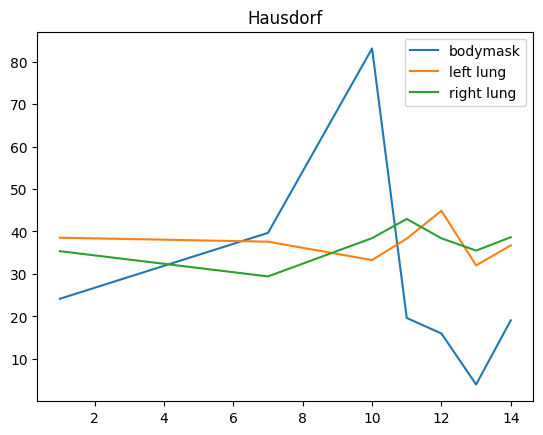

In [24]:
plt.figure()
plt.title("Hausdorf")
plt.plot(img_nums, hausdorff_bodymask_scores, '-', label="bodymask")
plt.plot(img_nums, hausdorff_left_scores, '-', label="left lung")
plt.plot(img_nums, hausdorff_right_scores, '-', label="right lung")
plt.legend()
plt.show()

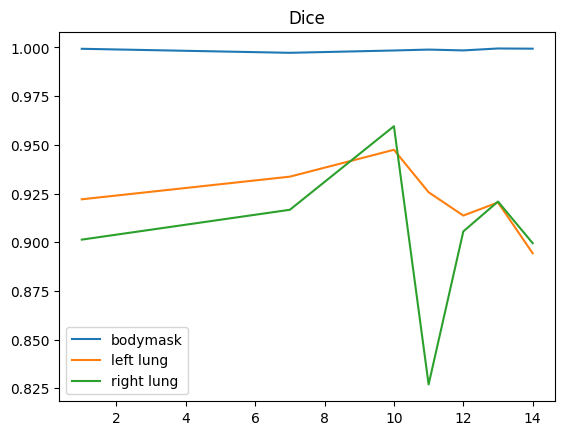

In [25]:
plt.figure()
plt.title("Dice")
plt.plot(img_nums, dice_bodymask_scores, '-', label="bodymask")
plt.plot(img_nums, dice_left_scores, '-', label="left lung")
plt.plot(img_nums, dice_right_scores, '-', label="right lung")
plt.legend()
plt.show()